# Softmax Regression

I followed the tutorial [here](https://towardsdatascience.com/ml-from-scratch-logistic-and-softmax-regression-9f09f49a852c) for this notebook (because the HOML one just glosses over the concepts).

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets

import logging

sns.set_theme(style = "whitegrid")

logging.basicConfig(
    level = logging.INFO,
    format = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)


A basic logistic regression class

In [12]:
class Sigmoid():
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))

In [13]:
class LogisticRegression():

    def __init__(self, n_iter = 3000, lr=1e-1):
        self.n_iter = n_iter
        self.lr = lr
        self.sigmoid = Sigmoid()

    def fit(self, X, y):
        # insert bias term
        X = np.insert(X, 0, 1, axis=1)
        
        n_features = X.shape[1]
        
        # random initilization of theta
        limit = np.sqrt(2 / n_features)
        self.coef_ = np.random.uniform(-limit, limit, (n_features,))

        # the batch gradient descent iterations
        for _ in range(self.n_iter):

            # calculate the logistic of predictions
            y_preds = self.sigmoid(X.dot(self.coef_))

            # gradients of cost function
            gradients = X.T.dot(y_preds - y)

            # update the weights
            self.coef_ -= self.lr * gradients

        return self

    def predict(self, X):
        X = np.insert(X, 0, 1, axis=1)
        y_preds = np.round(self.sigmoid(
            X.dot(self.coef_)
        )).astype(int)

        return y_preds

    def predict_proba(self, X):
        X = np.insert(X, 0, 1, axis=1)
        probas = self.sigmoid(X.dot(self.coef_))

        return probas

testing the class (my test)

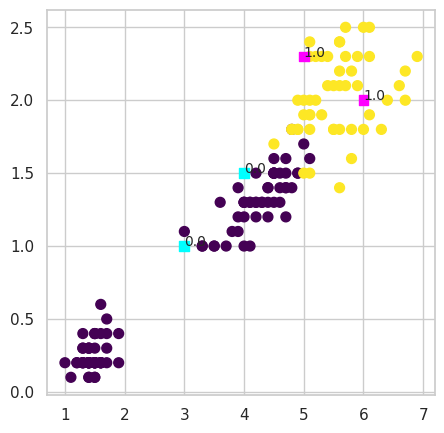

In [14]:
iris = datasets.load_iris()

X = iris["data"][:, 2:] # petal width
y = (iris["target"] == 2).astype(np.int32) # 1 if Iris-Virginica, else 0

log_reg = LogisticRegression()
log_reg.fit(X, y)

X_test = np.array(
    [
        [6.0, 2.0],
        [5.0, 2.3],
        [3.0, 1.0],
        [4.0, 1.5]
    ]
)
y_test = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)

_, ax = plt.subplots(figsize=(5,5))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", s=50)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="cool", s=50, marker="s")

# mark y_proba on the plot
for i, proba in enumerate(y_proba):
    ax.text(X_test[i, 0], X_test[i, 1], s=round(proba, 2), fontsize=10)

plt.show()

Testing the class (from the tutorial)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# could not import these for some reason
# from mlscratch.utils.metrics import accuracy_score
# from mlscratch.utils.preprocessing import StandardScaler
# from mlscratch.supervised.logistic import LogisticRegression

def test_logistic_iris():

    iris = datasets.load_iris()
    X = iris.data[iris.target != 0]
    y = iris.target[iris.target != 0]
    y[y==1] = 0
    y[y==2] = 1

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    scaler.fit_transform(X_train)
    scaler.transform(X_test)

    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_test)

    score = accuracy_score(y_test, y_preds)

    return score > 0.80

test_logistic_iris()

True

The exponent graph

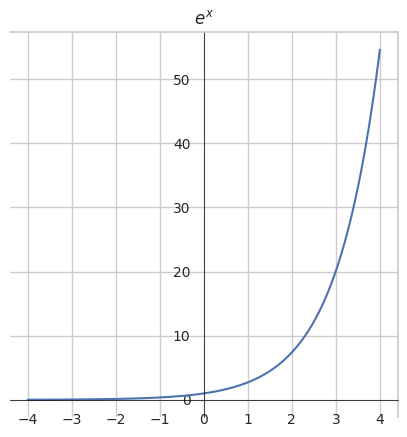

In [16]:
x = np.linspace(-4, 4, 100)
y = np.exp(x)

_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(x, y)
for p in ['left', 'bottom']:
    ax.spines[p].set_position('zero')
    ax.spines[p].set_color('black')
    ax.spines[p].set_linewidth(.5)
    # set tick color
    ax.tick_params(
        axis='both', which='major', color='k', labelsize=10
    )
plt.title("$e^x$")
plt.show()

For each instance, the Softmax Regression model computed a score for each class, then estimates the probability the instance belongs to each class by applying the softmax function to the scores:

$\hat{p}_k = \frac{e^{(s_k(x))}}{\sum_{j=1}^{K} e^{(s_k(x))}}$

- $K$ is the number of classes
- $s(x)$ is a vector containing the scores of each class for the instance x

For numerical stability, we normalize the softmax function:

$\frac{C \times e^{(s_k(x))}}{C \times \sum_{j=1}^{K} e^{(s_k(x))}} \
= \frac{e^{\ln C} \times e^{(s_k(x))}}{e^{\ln C} \times \sum_{j=1}^{K} e^{(s_k(x))}} \
= \frac{e^{(s_k(x) + \ln C)}}{\sum_{j=1}^{K} e^{(s_k(x) + \ln C)}}$

$C$ can be anything but commonly it is the negative of the max of the instance $x$ - shifts the values so the highest value is zero.

Out next implementation hence gives us:

$\hat{p}_j = \frac{e^{(s_j(x)-max(x))}}{\sum_j e^{(s_j(x)-max(x))}}$

In [17]:
class Softmax():
    def __call__(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)

## Training and Cost Function

**The Cross Entropy**

We want a model that predicts high probabilities for the target class, and low probabilities for the other classes.

$$ J(\theta) = - \frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} y_k^{i}\log(\hat{p}_k^i)$$

- $y$ - target probability that the instance belong to the target class
- cross entropy == log loss, when there are just two classes

For recap, the following is the log loss function:

$J(\theta) = -\frac{1}{m}\sum_{i=1}^m[y^{(i)}\log(\hat{p}^{(i)})+(1-y^{(i)})\log(1-\hat{p}^{(i)})]$

We will implement softmax using Gradient Descent, the gradient vector of this cost function is as follows:

$\nabla J(\theta)=\frac{1}{m}\sum_{i=1}^{m}(\hat{p}_k^i - y_k^i)x^i$

In [18]:
class OneHotEncoder:
    def __call__(self, X):
        n_samples = np.shape(X)[0]
        categories = np.unique(X)

        mappings = {}
        for id, category in enumerate(categories):
            mappings[category] = id

        one_hot_array = np.zeros((n_samples, len(categories)))
        for row_number, instance in enumerate(X):
            one_hot_array[row_number, mappings[instance]] = 1

        return one_hot_array

In [19]:
class SoftMaxRegression():
    def __init__(self, n_iter=3000, lr=1e-1):
        self.n_iter = n_iter
        self.lr = lr
        self.encoder = OneHotEncoder()
        self.softmax = Softmax()

    def fit(self, X, y):
        X = np.insert(X, 0, 1, axis=1)
        
        n_features = X.shape[1]
        n_classes = len(np.unique(y))

        # randomly initialize weights using glorot uniform initializer
        limit = np.sqrt(2 / n_features)
        self.coef_ = np.random.uniform(
            -limit, limit, (n_features, n_classes)
        )

        y_encoded = self.encoder(y)
        for _ in range(self.n_iter):

            y_preds = self.softmax(X.dot(self.coef_))
            gradients = X.T.dot(y_preds - y_encoded )
            self.coef_ -= self.lr * gradients

        return self

    def _calculate_probas(self, X):
        X = np.insert(X, 0, 1, axis=1)
        return self.softmax(X.dot(self.coef_))

    def predict(self, X):
        probas = self._calculate_probas(X)
        return np.argmax(probas, axis=1)
    
    def predict_proba(self, X):
        return self._calculate_probas(X)

In [20]:
def test_softmax_iris(X, y):

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    scaler.fit_transform(X_train)
    scaler.transform(X_test)

    clf = SoftMaxRegression()
    clf.fit(X_train, y_train)
    y_preds = clf.predict(X_test)

    score = accuracy_score(y_test, y_preds)

    return y_preds, score

iris = datasets.load_iris()
X = iris.data
y = iris.target
y_preds, score = test_softmax_iris(X, y)
score

0.9666666666666667